In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
from numpy.linalg import norm

from functools import partial

from PIL import Image
from skimage import transform


In [2]:
def zero_noise(dx):
    return 0

def uniform(a, b, dx):
    return np.random.uniform(a, b, size=dx.shape)

def percent_noise(dx, alpha=2):
    return np.random.uniform(-alpha/2*dx, +alpha/2*dx)
    

'''
Returns an approximation of the path that a drone would take given an array of change in position updates
DELTAS represents the change in position for each step along the path
NOISE_FN applies noise to each path update, causing a deviation compared to the true path, achieve by 
simply summing up the elements of DELTAS
path[0] represents the location of the drone after update deltas[0],
unless prepend_zero == True, in which case it is [0, 0].
'''
def simulate_input(deltas, noise_fn=zero_noise, prepend_zero=True, astype=int):
    path = np.zeros(deltas.shape)
    for i in range(len(path)):
        path[i] = path[i-1] + deltas[i] + noise_fn(deltas[i])
        
    if prepend_zero:
        return np.concatenate((np.zeros((1,2)), path), axis=0).astype(astype)
    else:
        return path.astype(astype)

def wide_uturn(leg=10):
    ones = np.ones((leg,1));
    zeros = np.zeros((leg,1));
    
    leg1 = np.hstack((ones, zeros))
    leg2 = np.hstack((zeros, ones))
    leg3 = np.hstack((-ones, zeros))
    return np.concatenate((leg1, leg2, leg3), axis=0)

def s_turn(short_leg=5):
    ones = np.ones((short_leg,1));
    zeros = np.zeros((short_leg,1));
    
    leg1 = np.hstack((ones, zeros))
    leg2 = np.hstack((zeros*2, -ones*2))
    leg3 = np.hstack((ones, zeros))
    return np.concatenate((leg1, leg2, leg3), axis=0)

In [3]:
def imread(path, grayscale=False):
    if grayscale:
        img = np.array(Image.open(path).convert('L'))
    else:
        img = np.array(Image.open(path))
    
    return np.swapaxes(img, 0, 1)

def imshow(img, ax=None, grayscale=False, **kwargs):
    if grayscale:
        kwargs['cmap'] = 'gray'
        kwargs['vmin'] = 0
        kwargs['vmax'] = 255
    
    img = np.swapaxes(img, 0, 1) # Convert back to (y,x)
    if img.ndim == 3: # RBG color
        if ax == None:
            plt.imshow(img, **kwargs)
        else:
            ax.imshow(img, **kwargs)
    else:
        if ax == None:
            plt.imshow(img, **kwargs)
        else:
            ax.imshow(img, **kwargs)

'''
    Returns a square slice of IMG with shape RADIUS*2 X RADIUS*2 
    with the point (X_CENTER, Y_CENTER) in the middle. 
'''
def sample_square(img, x_center, y_center, radius):
    return img[x_center - radius : x_center + radius, y_center - radius : y_center + radius]


'''
    If X_REF and Y_REF are NONE, TEST_IMG and REF_IMG must have same shape. 
    Can be grayscale n x m x 1 or color n x m x 3
    
    If X_REF and Y_REF are not NONE, take a slice of REF_IMG with 
    the point (X_REF, Y_REF) at the center that is the same shape as TEST_IMG.
    TEST_IMG must be a square.
    
    Returns the MSE difference between TEST_IMG and REF_IMG i.e insensitive to the size of the images
'''
def compare_images(test_img, ref_img, x_ref=None, y_ref=None):
    if x_ref == None and y_ref == None:
        assert test_img.shape == ref_img.shape
    elif x_ref != None and y_ref != None:
        # Take a slice from REF_IMG rather than the whole thing
        ref_img = sample_square(ref_img, x_ref, y_ref, test_img.shape[0] // 2)
    else:
        raise ValueError("X_REF and Y_REF must both be either None or not None.")
        
    # Sum of squares difference
    mse = np.sum(np.square(test_img - ref_img)) / ref_img.size
    return mse

'''
Sample a slice of REF_IMG that is the same shape as TEST_IMG, centered at each location in SEARCH_COORDS.

Return the (x,y) pair that is centered at the slice of REF_IMG that best matches TEST_IMG.
'''
def search(search_coords, test_img, ref_img, threshold=None):
    best_match = float('inf')
    best_coords = (None, None)
    for loc in search_coords:
        match = compare_images(test_img, ref_img, *loc)
        if threshold != None and match < threshold:
            return (match, loc)
        if match < best_match:
            best_match = match
            best_coords = loc
    return (best_match, best_coords)

def taxicab_norm(x1, y1, x2, y2):
    return abs(x1 - x2) + abs(y1 - y2)

def euclid_norm(x1, y1, x2, y2):
    return np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))

'''
Returns the locus of points a certain distance R from (X,Y)
'''
def circular_path(x, y, r, norm_fn=taxicab_norm, line_width=1):
    x, y = int(x), int(y)
    path = []
    for xi in range(x-r, x+r+1):
        for yi in range(y-r, y+r+1):
            d = norm_fn(x, y, xi, yi)
            if abs(d-r) < float(line_width)/2:
                path.append((xi, yi))
    return np.array(path)

def spiral_path(x, y, max_r, **kwargs):
    path = []
    for r in range(max_r+1):
        path.extend(circular_path(x, y, r, **kwargs))
    return np.array(path)

In [4]:
import time

from scipy.special import expit
def derive_confidence(mse):
    return 1 - expit(mse)



In [5]:
'''
Given:
    1) Previous best estimate
    2) A noisy, perhaps innacurate change in position from the onboard sensors
    3) The estimate from the image search algorithm and the confidence of the match as a decimal
Calculate:
    1) The estimated change in position
    2) The next best estimate
'''
def next_est(est_prev, delta_inert, est_img, c=0.5):
    delta_next = delta_inert * (1-c) + (est_img - est_prev) * c
    est_next = (est_prev + delta_inert) * (1-c) + est_img * c
    return (delta_next, est_next)

# TODO replace (x,y) with np.array = position

# Set up some initial conditions and parameters
search_radius = 40
spiral = spiral_path(0, 0, search_radius) # TODO fix this
FIELD_OF_VIEW = 100

# Load the map
gs = False
ref_img = imread('manhattan.jpg', gs) # The full reference image
# ref_img = sample_square(ref_img, 1000, 1000, 200) # crop it a bit

# Set out a path, starting at START_POS and following updates along DELTAS_TRUE
start_pos = np.array([[1500,850]])
deltas_true = (np.vstack((np.vstack([s_turn(1) for _ in range(3)]), wide_uturn(3))) * 25).astype(np.float64)
path_true = np.cumsum(np.vstack((start_pos, deltas_true)), axis=0)

# Simulate some input from the onboard sensors and camera
deltas_inert = (deltas_true - np.array([0, -1])).astype(np.float64) # Add systematically biased error 
captured_imgs = [sample_square(ref_img, path_true[i,0].astype(int), path_true[i,1].astype(int), FIELD_OF_VIEW) for i in range(len(path_true))]

In [13]:
# Build a list of estimated positions
path_est = np.zeros_like(path_true) # Start filling in at index 1
path_est[0] = start_pos

for i in range(1, len(path_true)):
    print("[{}] True Position: {}".format(i, path_true[i]))
    
    # Update the current best estimate, i.e. path_est[i], using data from the onboard sensors
    path_est[i] = path_est[i-1] + deltas_inert[i-1]
    print("\t{} using data from onboard sensors".format(path_est[i]))
    
    # Search the database for a match, beginning at the current best estimate, i.e. path_est[i]
    search_path = spiral + path_est[i].astype(int)
    mse, img_pos_est = search(search_path, captured_imgs[i], ref_img, threshold=1.0)
    c = derive_confidence(mse) * True * .1
    print("\t{} from image recognition with confidence of {}".format(img_pos_est, c))

    # Synthesize
    path_est[i] = path_est[i] * (1-c) + img_pos_est * c
    
    print("[{}] Best Estimate: {}".format(i, path_est[i]))
    print("[{}] Error: {}\n".format(i, euclid_norm(path_true[i,0], path_true[i,1], path_est[i,0], path_est[i,1])))

[1] True Position: [1525.  850.]
	[1525.  851.] using data from onboard sensors
	[1525  850] from image recognition with confidence of 0.05
[1] Best Estimate: [1525.    850.95]
[1] Error: 0.9499999999999318

[2] True Position: [1525.  800.]
	[1525.    801.95] using data from onboard sensors
	[1525  800] from image recognition with confidence of 0.05
[2] Best Estimate: [1525.      801.8525]
[2] Error: 1.85249999999985

[3] True Position: [1550.  800.]
	[1550.      802.8525] using data from onboard sensors
	[1550  800] from image recognition with confidence of 0.05
[3] Best Estimate: [1550.        802.709875]
[3] Error: 2.7098749999997835

[4] True Position: [1575.  800.]
	[1575.        803.709875] using data from onboard sensors
	[1575  800] from image recognition with confidence of 0.05
[4] Best Estimate: [1575.          803.52438125]
[4] Error: 3.5243812499998057

[5] True Position: [1575.  750.]
	[1575.          754.52438125] using data from onboard sensors
	[1575  750] from image re

In [14]:
path_est_no_img = np.cumsum(np.vstack((start_pos, deltas_inert)), axis=0)
path_true[-1], path_est[-1], path_est_no_img[-1]

(array([1650.,  775.]),
 array([1650.        ,  786.45292795]),
 array([1650.,  793.]))

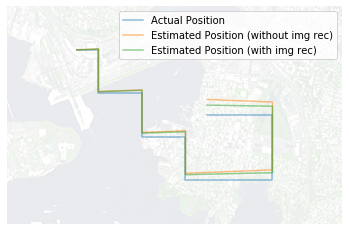

In [19]:
xlim = path_true.min(axis=0)[0] - FIELD_OF_VIEW//2, path_true.max(axis=0)[0] + FIELD_OF_VIEW//2
ylim = path_true.min(axis=0)[1] - FIELD_OF_VIEW//2, path_true.max(axis=0)[1] + FIELD_OF_VIEW//2
xlim, ylim

# Plot the results
fig, ax = plt.subplots(1,1)
 
imshow(ref_img, ax, gs, alpha=.1)
plt.plot(path_true[:,0], path_true[:,1], alpha=.5, label="Actual Position")
plt.plot(path_est_no_img[:,0], path_est_no_img[:,1],  alpha=.5, label="Estimated Position (without img rec)")
plt.plot(path_est[:,0], path_est[:,1],  alpha=.5, label="Estimated Position (with img rec)")
plt.axis('equal')
plt.ylim(ylim)
plt.xlim(xlim)
plt.axis('off')
plt.legend()

In [8]:

#     search_radius = euclid_norm(true_pos[0], true_pos[1], est_prev[0], est_prev[1])

In [9]:
# Apply image recognition to improve estimate
path_est_img = []
weights = []
for i, (true_loc, inert_est_loc) in enumerate(zip(path_true, path_est_inert)):
    # Take a picture of the ground
    img = sample_square(ref_img, true_loc[0], true_loc[1], FIELD_OF_VIEW)
    
    # Use image recognition to come up with an alternate estimate
    # Begin the search at the current best estimate
    start = time.time()
    search_path = spiral + inert_est_loc
    mse, img_est = search(search_path, img, ref_img, threshold=1.0)
    end = time.time()

    confidence = derive_confidence(mse)
    path_est_img.append(img_est)
    weights.append(confidence)
    
    print(i, end - start, true_loc, inert_est_loc, confidence, img_est)


path_est_img = np.array(path_est_img)
weights = np.array(weights)

NameError: name 'path_est_inert' is not defined

In [ ]:
np.diff(path_true, axis=0) - np.diff(path_est_img, axis=0)
deltas - (deltas - np.array([1,0]))

In [ ]:
def correct_estimate(inert_est, img_est, confidence=0.5, astype=int):
    return ((1-confidence) * inert_est + confidence * img_est).astype(astype)
    
def correct_estimate(inert_est, img_est, confidence=0.5, astype=int):
    est = np.copy(img_est)
    for i in range(1, est.shape[0]):
        print(i, est[i-1], img_est[i-1])
        term1 = (1-confidence) * est[i-1]
        print("term1", term1)
        term2 = confidence * img_est[i-1]
        print("term2", term2)
        est[i] = (term1 + term2).astype(astype)
    return est

In [ ]:
path_est_img[0]

In [ ]:
# Combine the estimates from inertial navigation and image recognition
# TODO: need to feed this answer back into the algorithm. Otherwise, it doesn't actually do incremental updates
# path_est = correct_estimate(path_est_inert, path_est_img, np.tile(weights, (2,1)).T)
path_est = correct_estimate(path_est_inert, path_est_img, weights)

In [ ]:
xlim = path_true.min(axis=0)[0] - FIELD_OF_VIEW//2, path_true.max(axis=0)[0] + FIELD_OF_VIEW//2
ylim = path_true.min(axis=0)[1] - FIELD_OF_VIEW//2, path_true.max(axis=0)[1] + FIELD_OF_VIEW//2
xlim, ylim

# xlim = end_pos[0] - FIELD_OF_VIEW//2, end_pos[0] + FIELD_OF_VIEW//2
# ylim = end_pos[1] - FIELD_OF_VIEW//2, end_pos[1] + FIELD_OF_VIEW//2